In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from timeit import default_timer
from collections import namedtuple
import pylab as plt
import os
plt.style.use('ggplot')
float_type = tf.float64
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import gpflow as gp
from bayes_tec.datapack import DataPack
from bayes_tec.utils.data_utils import make_coord_array, calculate_weights
from timeit import default_timer
import pylab as plt
plt.style.use('ggplot')
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import sys
from scipy.cluster.vq import kmeans2
from bayes_tec.frames import ENU

jitter = 1e-6


/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __n

In [1]:
import enum
import numpy as np
import tensorflow as tf

from gpflow.transforms import Identity
float_type = tf.float64

class Parameter(object):
    def __init__(self, name, value, transform=Identity(), prior=None,
                 trainable=True, dtype=float_type, unconstrained_tensor=None):
        self.name = name
        self.prior = prior          # pylint: disable=W0201
        self.transform = transform  # pylint: disable=W0201
        if unconstrained_tensor is None:
            self._initial_value_tensor = tf.convert_to_tensor(value,dtype=dtype)
            self._unconstrained_tensor_ref = tf.get_variable(name, dtype=dtype, 
                    initializer=self.transform.backward_tensor(self._initial_value_tensor), 
                    trainable=trainable,
                    use_resource=True)
            self._unconstrained_tensor = tf.identity(self.unconstrained_tensor_ref)
        else:
            self._unconstrained_tensor_ref = None
            self._unconstrained_tensor = unconstrained_tensor
            self._initial_value_tensor = self.transform.forward_tensor(unconstrained_tensor)
        self._constrained_tensor = self.transform.forward_tensor(self.unconstrained_tensor)
        self._prior_tensor = self._build_prior(self.unconstrained_tensor, self.constrained_tensor)

    @property
    def unconstrained_tensor_ref(self):
        return self._unconstrained_tensor_ref
    
    @property
    def unconstrained_tensor(self):
        return self._unconstrained_tensor

    @property
    def constrained_tensor(self):
        return self._constrained_tensor

    @property
    def prior_tensor(self):
        """log P(constrained_param) + log |det transform(unconstrained_param)|"""
        return self._prior_tensor
  
    @property
    def initializer(self):
        if self.unconstrained_tensor_ref is None:
            raise ValueError("No variable referenced")
        return self.unconstrained_tensor_ref.initializer

    def assign_op(self, value):
        if self.unconstrained_tensor_ref is None:
            raise ValueError("No variable referenced")
        return tf.assign(self._unconstrained_tensor_ref,self.transform.backward_tensor(value))
        
    def _build_prior(self, unconstrained_tensor, constrained_tensor):
        prior_name = '{}_logp'.format(self.name)

        if self.prior is None:
            logp_param = tf.constant(0.0, float_type)
        else:
            logp_param = self.prior(constrained_tensor)

        log_jacobian = self.transform.log_jacobian_tensor(unconstrained_tensor)
        
        return tf.squeeze(tf.add(logp_param, log_jacobian, name=prior_name))

In [3]:
class Kernel(object):
    def __init__(self, time_lengthscale, dir_lengthscale, ant_lengthscale, dot_var, dot_offset,
                active_dims_time=None,active_dims_dir=None,active_dims_ant=None):
        self.dir_lengthscale = dir_lengthscale
        self.time_lengthscale = time_lengthscale
        self.ant_lengthscale = ant_lengthscale
        self.dot_var = dot_var
        self.dot_offset = dot_offset
        self.active_dims_time = active_dims_time or slice(0,1,1)
        self.active_dims_dir = active_dims_dir or slice(1,3,1)
        self.active_dims_ant = active_dims_ant or slice(3,5,1)
        
    def scaled_square_dist_batched(self,X, X2, lengthscale):
        """
        X: tensor B, N, D
        X2: tensor B, M, D (or 1, M, D) and will be broadcast to B, M ,D
        Return:
        tensor B, N, M
        """
        # Clipping around the (single) float precision which is ~1e-45.
        X = X / lengthscale
        Xs = tf.reduce_sum(tf.square(X), axis=2)#B,N

        if X2 is None:
            dist = -2.*tf.matmul(X,X,transpose_b=True)
            dist += Xs[:,:,None] + Xs[:,None,:]
            return tf.maximum(dist, 1e-40)

        # B (1), M, D
        X2 = X2 / lengthscale
        X2s = tf.reduce_sum(tf.square(X2), axis=2)# B (1), M 
        dist = -2 * tf.matmul(X, X2, transpose_b=True)
        dist += Xs[:,:,None] + X2s[:,None,:]
        return dist
    
    def scaled_square_dist(self,X, X2, lengthscale):
        """
        X: tensor N, D
        X2: tensor M, D
        Return:
        tensor N, M
        """
        # Clipping around the (single) float precision which is ~1e-45.
        X = X / lengthscale
        Xs = tf.reduce_sum(tf.square(X), axis=1)#N

        if X2 is None:
            dist = -2.*tf.matmul(X,X,transpose_b=True)
            dist += Xs[:,None] + Xs[None,:]
            return tf.maximum(dist, 1e-40)

        # M, D
        X2 = X2 / lengthscale
        X2s = tf.reduce_sum(tf.square(X2), axis=1)#  M 
        dist = -2 * tf.matmul(X, X2, transpose_b=True)
        dist += Xs[:,None] + X2s[None,:]
        return dist
    
    def _clipped_sqrt(self, r2):
        # Clipping around the (single) float precision which is ~1e-45.
        return tf.sqrt(tf.maximum(r2, 1e-40))

    
    def K(self, X, X2=None):
        """Returns the covariance at X and X2.
        (dot_offset + dot_var*X.X2) * M52(time) * RBF(dir) * M12(ant)
        Args:
        :param X: float Tensor [N, ndims]
        :param X2: float Tensor [M, ndims]
        Returns:
        float Tensor [N,M]
        """
        Xt = X[:,self.active_dims_time]
        Xd = X[:,self.active_dims_dir]
        Xa = X[:,self.active_dims_ant]
        
        if X2 is None:
            X2t = None
            X2d = None
            X2a = None
        else:
            X2t = X2[:,self.active_dims_time]
            X2d = X2[:,self.active_dims_dir]
            X2a = X2[:,self.active_dims_ant]
        
        
        r2t = self.scaled_square_dist(Xt, X2t, self.time_lengthscale)
        rt = self._clipped_sqrt(r2t)
        r2d = self.scaled_square_dist(Xd, X2d, self.dir_lengthscale)
        ra = self._clipped_sqrt(self.scaled_square_dist(Xa, X2a, self.ant_lengthscale))
        
        combined_exp = tf.accumulate_n([np.sqrt(5.)*rt, 0.5*r2d, ra])
        combined_exp = tf.exp(-combined_exp)
        dot_kern = self.dot_offset + self.dot_var * tf.matmul(Xd, Xd if X2d is None else X2d, transpose_b=True)
        time_m52 = (1. + np.sqrt(5.) * rt + (5./3.) * r2t)
        
        return combined_exp*dot_kern*time_m52
    
    def Kdiag(self, X):
        """Returns the diag of the covariance at X.
        Args:
        :param X: float Tensor [N, ndims]
        Returns:
        float Tensor [N]
        """
        return self.dot_var*tf.linalg.norm(X,axis=-1,keepdims=False) + self.dot_offset


In [4]:
def gp_kern():
    ###
    # Define kernel 
    kern_time = gp.kernels.Matern52(1, active_dims = slice(0,1,1))
    kern_time.lengthscales = 99.0
#     kern_time.lengthscales.trainable = train_time
    kern_time.variance.trainable = False
    kern_dir = gp.kernels.RBF(2, active_dims = slice(1,3,1))
    kern_dir.lengthscales = 1.150
#     kern_dir.lengthscales.trainable = train_dir
    kern_dir.variance.trainable = False
    kern_ant = gp.kernels.Matern12(2, active_dims = slice(3,5,1),variance=1.)
    kern_ant.lengthscales = 11.0
#     kern_ant.lengthscales.trainable = train_ant
    kern_ant.variance.trainable = False
    # dependence on distance from center 
    kern_dot = gp.kernels.Polynomial(2, degree=1, variance=0.01211, offset=0.81261, active_dims = slice(1,3,1))
#     kern_freq = gp.kernels.RBF(1, active_dims = slice(5,6,1))
#     kern_freq.lengthscales = 2.
    kern = gp.multioutput.SharedIndependentMok(kern_time*kern_dir*kern_ant*kern_dot,1)
    return kern

In [6]:
def make_solsets(datapack,output_solset, screen_res=15, extend = 0., solset='sol000'):
    screen_solset = "screen_{}".format(output_solset)
    
    datapack.switch_solset(solset)
    datapack.select(ant=None,time=None, dir=None, freq=None, pol=slice(0,1,1))
    axes = datapack.__getattr__("axes_{}".format('phase'))

    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    patch_names, directions = datapack.get_sources(axes['dir'])
    timestamps, times = datapack.get_times(axes['time'])
    freq_labels, freqs = datapack.get_freqs(axes['freq'])
    pol_labels, pols = datapack.get_pols(axes['pol'])

    Npol, Nd, Na, Nf, Nt = len(pols), len(directions), len(antennas), len(freqs), len(times)
    
#     screen_directions = dialated_faceted(directions.ra.rad.mean(), directions.dec.rad.mean(),
#                                         N=screen_res)

    screen_ra = np.linspace(np.min(directions.ra.rad) - extend*np.pi/180., 
            np.max(directions.ra.rad) + extend*np.pi/180., screen_res)
    screen_dec = np.linspace(max(-90.*np.pi/180.,np.min(directions.dec.rad) - extend*np.pi/180.), 
            min(90.*np.pi/180.,np.max(directions.dec.rad) + extend*np.pi/180.), screen_res)
    screen_directions = np.stack([m.flatten() \
            for m in np.meshgrid(screen_ra, screen_dec, indexing='ij')], axis=1)
    screen_directions = ac.SkyCoord(screen_directions[:,0]*au.rad,screen_directions[:,1]*au.rad,frame='icrs')
    Nd_screen = screen_res**2

    datapack.switch_solset(output_solset, 
            array_file=DataPack.lofar_array, 
            directions = np.stack([directions.ra.rad,directions.dec.rad],axis=1), patch_names=patch_names)
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)   
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)


    datapack.switch_solset(screen_solset, 
            array_file = DataPack.lofar_array, 
            directions = np.stack([screen_directions.ra.rad,screen_directions.dec.rad],axis=1))
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)

    datapack.switch_solset(solset)
    
def get_solset_coords(datapack,solset):
    datapack.switch_solset(solset)
    axes = datapack.axes_phase
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    patch_names, directions = datapack.get_sources(axes['dir'])
    timestamps, times = datapack.get_times(axes['time'])
    pol_labels, pols = datapack.get_pols(axes['pol'])
    
    antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
    X_a = np.array([antennas_enu.east.value,
                    antennas_enu.north.value]).T/1000.
    X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), directions.dec.deg - directions.dec.deg.mean()]).T
    X_t = (times.mjd*86400 - times[0].mjd*86400.)[:,None]
    
    return X_t, X_d, X_a

UpdateResult = namedtuple('UpdateResult',['x_samples','z_samples','log_prob', 'acceptance','step_size'])

class TargetDistribution(object):
    def __init__(self, kern, 
                 z_tm1, 
                 X, 
                 last_X, 
                 Y, 
                 Y_std, 
                 freqs, 
                 L11, 
                 num_chains,
                 max_lik=True, 
                 num_sigma_points=10,
                 step_size=0.01,
                 sigma_amp=1.,
                 approximate_posterior = False):
        """
        The target distribution of the Bayes filter.
        Args:
        :param z_tm1: float Tensor [S, num_chains, M, Np]
        :param X: float Tensor [N,K]
        :param last_X: float Tensor [Np, K]
        :param Y: float Tensor [D, N, Nf]
        :param Y_std: float Tensor [D, N, Nf]
        :param freqs: float Tensor [Nf]
        :param L11: float Tensor [M, Np, Np]
        """
        self.M = tf.shape(z_tm1)[2]
        self.S = tf.shape(z_tm1)[0]
        self.num_chains = num_chains#tf.shape(z_tm1)[1]
        self.num_sigma_points = tf.convert_to_tensor(num_sigma_points, dtype=tf.int32)
        
        self.N = tf.shape(Y)[1]
        
        #M, N, N
        self.K00 = kern(X)
        #M, N, N
        self.L00 = tf.cholesky(self.K00 + tf.cast(jitter,tf.float64)*tf.eye(tf.shape(self.K00)[-1],dtype=tf.float64))
#         #M, Np, Np
        self.K11 = kern(last_X)
        #M, Np, Np
        self.L11 = tf.cholesky(self.K11 + tf.cast(jitter,tf.float64)*tf.eye(tf.shape(self.K11)[-1],dtype=tf.float64))#L11#kern()
        #M, Np, N
        self.K10 = kern(last_X, X)
        #S, num_chains, M, N
        self.z_tm1 = z_tm1
        #D, N, Nf
        self.Y = Y
        #D, N, Nf
        self.Y_std = Y_std
        #Nf
        self.freqs = freqs
        
        self.step_size = tf.get_variable(
                name='step_size',
                initializer=lambda: tf.constant(step_size,dtype=tf.float64),
                use_resource=True,
                dtype=tf.float64,
                trainable=False)
        
        self.sigma_amp = sigma_amp
        self.max_lik = max_lik
        self.approximate_posterior = approximate_posterior
        
    def likelihood(self, x_t):
        """
        Calculate the likelihood of Y given hidden_state.
        I.e.
            sum_i log[P(Y_j(X_i) | X_i)]
        If Y_j in C^Nf and assuming independence between 
        real, imag, and components we get,
            sum_i sum_j log[P(Re[Y_j(X_i)] | X_i)] 
                        + log[P(imag[Y_j(X_i)] | X_i)]
        Args:
        :param x_t: float Tensor [num_chains, M, N+H]
        Returns:
        float Tensor [num_chains]
        """
        #num_chains, N
        x_t = x_t[:, 0, :self.N]
        #Nf
        tec_conv = tf.div(tf.cast(-8.448e6,tf.float64),self.freqs,name='tec_conv')
        #num_chains, N, Nf
        phi = tec_conv*x_t[:,:,None]
        g_real = tf.cos(phi)
        g_imag = tf.sin(phi)
        #D, num_chains, N, Nf
        g = tf.stack([g_real, g_imag],axis=0,name='g')
        L = tfp.distributions.MultivariateNormalDiag(loc=g, scale_identity_multiplier = self.sigma_amp,#scale_diag=self.sigma_amp*self.Y_std[:, None,:,:]
                                                     name='data_likelihood')        
        #D,num_chains, N
        logp = L.log_prob(self.Y[:,None,:,:])
        #num_chains
        return tf.reduce_sum(logp,axis=[0, 2])

    def prior_logp(self, x_t):
        """
        Calculate the predict step, i.e.
            log[P(X_i | Y_i-1)] = log E_i-1[P(X_i | X_i-1)]
                                = log sum_s P(X_i | X_i-1,s) - log S
                                = logsumexp_s log[P(X_i | X_i-1,s)] - log S
            If we transform the variables through,
            X = L.Z + m => log P(X) = log P(Z) - log det L
            log[P(X_i | X_i-1,s)] = log[P(Z_i | Z_i-1,s)] - log det L_i
        Assumes hidden state is a GP marginal.
        Args:
        :param x_t: float Tensor [num_chains, M, N]
        Returns:
        [num_chains]
        """
        
        def _approx_posterior():
            #S, num_chains, M, Np,1
            x_tm1 = tf.einsum('mij,snmj->snmi',self.L11, self.z_tm1)[..., None]
            #num_chains, M, Np,1
            m_tm1 = tf.reduce_mean(x_tm1,axis=0)
            #num_chains, M, Np,Np
            m2 = tf.matmul(m_tm1,m_tm1, transpose_b=True)
            #num_chains, M, Np, Np
            C_tm1 = tf.reduce_mean(tf.matmul(x_tm1, x_tm1,transpose_b=True), axis=0) - m2
            
        def _measure_expectation():
            s = tf.minimum(self.num_sigma_points, tf.shape(self.z_tm1)[0])
            shuffle_index = tf.random_shuffle(tf.range(tf.shape(self.z_tm1)[0],dtype=tf.int32))[:s]
            #s, num_chains, M, Np
            z_tm1 = tf.gather(self.z_tm1, shuffle_index, axis=0,name='z_tm1')
            x_tm1 = tf.einsum('mij,snmj->snmi',self.L11, z_tm1)

            # log[P(Z_i | Z_i-1,s)] = log[N[m_i, C]] + log
            #M, Np, N
            A = tf.matrix_triangular_solve(self.L11,self.K10)
    #         #s, num_chains, M, Np, N
    #         A_expand = tf.tile(A[None, None, :, :, :], [s, self.num_chains,1,1,1])
    #         #s, num_chains, M, N
    #         m = tf.matmul(A_expand, z_tm1[:,:,:,:,None],transpose_a=True)[:,:,:,:,0]
            #s, num_chains, M, N
            m = tf.einsum('mij,snmi->snmj',A,x_tm1)
            #M, N, N
            C = self.K00 - tf.matmul(A, A, transpose_a=True)
            #M, N, N
            L = tf.cholesky(C + tf.cast(jitter,tf.float64)*tf.eye(tf.shape(C)[2],dtype=tf.float64))
            P = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=L[None, None,:,:,:])
            #s, num_chains, M
            log_prob = P.log_prob(x_t) - tf.reduce_sum(tf.log(tf.matrix_diag_part(self.L00)),axis=1)
            #s, num_chains
            log_prob = tf.reduce_sum(log_prob, axis=2)
            #num_chains
            log_prob = tf.reduce_logsumexp(log_prob,axis=0) - tf.log(tf.cast(s,tf.float64))
            log_prob.set_shape(tf.TensorShape([self.num_chains]))
            return log_prob
        
        approx_logp = _approx_posterior()
        measure_logp = _measure_expectation()
        return measure_logp
        
        log_prob = tf.cond(self.approximate_posterior,
                          lambda: approx_logp,
                          lambda: measure_logp)
            
        log_prob.set_shape(tf.TensorShape([self.num_chains]))
        return log_prob
    
    def unnormalized_logp(self,z_t):
        """
        Returns the unnormalized probability density of the Bayes filter posterior.
        log P(y_t | z_t) + log (1/S) sum_s P(z_t | z^s_t-1)
        Args:
        :param z_t: float Tensor [num_chains, M*(N+H)]
        Returns:
        [num_chains]
        """
        #num_chains, M, N+H
        z_t = tf.cast(tf.reshape(z_t,[self.num_chains, self.M, -1]),tf.float64)
        #num_chains, M, N+H
        x_t = tf.einsum('mij,nmj->nmi', self.L00, z_t)
        
#         #num_chains, M, N, N
#         L00_expand = tf.tile(self.L00[None, :, :self.N, :self.N], [self.num_chains, 1,1,1])
#         #num_chains, N
#         x_t = tf.matmul(L00_expand, z_t[:, :, :self.N, None])[:, 0, :, 0]

        max_lik_logp = self.likelihood(x_t)
        full_post_logp = max_lik_logp + self.prior_logp(x_t)
        logp = tf.cond(self.max_lik,
                       lambda: max_lik_logp, 
                       lambda: full_post_logp)
        return logp#self.likelihood(x_t) + self.prior_logp(x_t)
    
    def sample(self,num_samples=10, num_leapfrog_steps=2, target_rate=0.75):
        
        
        
        hmc = tfp.mcmc.HamiltonianMonteCarlo(
                        target_log_prob_fn=self.unnormalized_logp,
                        num_leapfrog_steps=num_leapfrog_steps,#tf.random_shuffle(tf.range(3,60,dtype=tf.int64))[0],
                        step_size=self.step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(target_rate=target_rate))
#                         step_size_update_fn=lambda v, _: v)

        #num_chains, M, Np
        q0 = tf.reduce_mean(self.z_tm1,axis=0)
        q0 = tf.reshape(q0,(self.num_chains, -1))
#         q0.set_shape(tf.TensorShape([self.num_chains, None]))
        # Run the chain (with burn-in).
        z_samples, kernel_results = tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=0,
            current_state=q0,
            kernel=hmc)
        
        avg_acceptance_ratio = tf.reduce_mean(tf.exp(tf.minimum(kernel_results.log_accept_ratio, 0.)),name='avg_acc_ratio')
        posterior_log_prob = tf.reduce_sum(kernel_results.accepted_results.target_log_prob,name='marginal_log_likelihood')
        
        z_samples = tf.reshape(z_samples, tf.concat([tf.shape(z_samples)[:2], [self.M], [-1]],axis=0))
        x_samples = tf.einsum("mij,snmj->snmi",self.L00,z_samples)
        
        res = UpdateResult(x_samples, z_samples, posterior_log_prob, avg_acceptance_ratio, kernel_results.extra.step_size_assign)
        return res 

In [17]:
# datapack = '/home/albert/git/bayes_tec/scripts/data/DR2_full_smoothed.h5'

# ant_sel = slice(47,49,1)#'RS210HBA'#slice(1,None,1)
# time_sel = slice(0,50,1)
# dir_sel = slice(39,41,1)
# freq_sel = slice(0,None,1)
# pol_sel = slice(0,1,1)

# with DataPack(datapack,readonly=True) as datapack:
#     datapack.select(ant=ant_sel,
#                     freq=freq_sel,
#                     time=time_sel,
#                     dir=dir_sel, 
#                     pol=pol_sel)
#     datapack.switch_solset('sol000')
#     phase, axes = datapack.phase
#     _, Nd, Na, Nf, Nt = phase.shape
# #     amp, axes = datapack.amplitude
#     axes = datapack.axes_phase
#     patch_names, directions = datapack.get_sources(axes['dir'])
#     _, times = datapack.get_times(axes['time'])
#     _, freqs = datapack.get_freqs(axes['freq'])
#     antenna_labels, antennas = datapack.get_antennas(axes['ant'])

# antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
# X_a = np.array([antennas_enu.east.value,
#                 antennas_enu.north.value]).T/1000.
# X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), directions.dec.deg - directions.dec.deg.mean()]).T
# X_t = (times.mjd*86400 - times[0].mjd*86400.)[:,None]

# X = make_coord_array(X_t, X_d, X_a)

# with tf.Session(graph=tf.Graph()) as sess:
#     X_pl = tf.placeholder(tf.float64,shape=X.shape)
#     kern1 = gp_kern()
#     kern2 = Kernel(99.,1.15,11.,0.01211,0.81261)
#     K1,K2 = sess.run([kern1.K(X_pl,full_output_cov=False), kern2.K(X_pl)],{X_pl:X})
    
    

In [18]:
# plt.imshow(K1[0,:,:])
# plt.show()
# plt.imshow(K2[:,:])
# plt.show()
# plt.imshow(K2[:,:]-K1[0,:,:])
# plt.colorbar()
# plt.show()

In [19]:
# def is_pos_def(x):
#     return np.all(np.linalg.eigvals(x) >= 0)
# cond1 = []
# cond2 = []
# perts = []
# pert = 1.
# while True:
# #     print(pert)
#     perts.append(pert)
#     _K1 = K1 + pert*np.eye(K1.shape[1])
#     _K2 = K2 + pert*np.eye(K1.shape[1])
#     cond1.append(np.linalg.cond(_K1[0,:,:]))
#     cond2.append(np.linalg.cond(_K2))
#     pert /= 2.
    
#     c1, c2 = is_pos_def(_K1[0,:,:]),is_pos_def(_K2)
#     if not (c1 and c2):
#         print(perts[-1],c1, c2)
#         break
        
# plt.plot(cond1)
# plt.plot(cond2)
# plt.yscale('log')
# plt.show()

In [ ]:
posterior_solset = 'posterior_sol_15'
datapack = '/home/albert/git/bayes_tec/scripts/data/DR2_full_smoothed.h5'
output_folder='./nonlinear_rgp/test'
os.makedirs(output_folder,exist_ok=True)

ant_sel = 'RS210HBA'#slice(1,None,1)
time_sel = slice(0,50,1)
dir_sel = slice(39,40,1)
freq_sel = slice(0,None,1)
pol_sel = slice(0,1,1)

with DataPack(datapack,readonly=True) as datapack:
    make_solsets(datapack, posterior_solset, screen_res=15, extend = 0., solset='sol000')
    datapack.select(ant=ant_sel,
                    freq=freq_sel,
                    time=time_sel,
                    dir=dir_sel, 
                    pol=pol_sel)
    datapack.switch_solset('sol000')
    phase, axes = datapack.phase
    _, Nd, Na, Nf, Nt = phase.shape
#     amp, axes = datapack.amplitude
    datapack.switch_solset(posterior_solset)
    axes = datapack.axes_phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    _, times = datapack.get_times(axes['time'])
    _, freqs = datapack.get_freqs(axes['freq'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])

gains = np.exp(1j*(phase + 0.*np.random.normal(size=phase.shape)))
#Nt,Nd,Na,Nf
gainsT = gains[0,...].transpose((3,0,1,2))

#2, Nt, Nd, Na, Nf
Y = np.stack([gainsT.real, gainsT.imag], axis = 0)
Y_var = calculate_weights(Y,indep_axis=1, N=4,phase_wrap=False,min_uncert=0.01)


antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
X_a = np.array([antennas_enu.east.value,
                antennas_enu.north.value]).T/1000.
X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), directions.dec.deg - directions.dec.deg.mean()]).T
X_t = (times.mjd*86400 - times[0].mjd*86400.)[:,None]

# ###
# # custom uncertainties
# #Nd,Na,Nf
# flags = np.where(flag_facets(phase, X_d))
# flag_dirs = np.unique(flags[0])
# select_dirs = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))[0]
# Y_var[:,:,flags[0], flags[1], flags[2]] += 300.

D = 2

###
# Get screen directions

In [31]:
with datapack:
    datapack.select(ant=ant_sel,
                    freq=freq_sel,
                    time=time_sel,
                    dir=slice(0,None,1), 
                    pol=pol_sel)
    _, X_screen_d, _ = get_solset_coords(datapack, 'screen_{}'.format(posterior_solset))


def _make_coord_array(*X):
    return tf.py_func(make_coord_array,X,tf.float64,stateful=False)

from tensorflow.python import debug as tf_debug

with tf.Session(graph=tf.Graph()) as sess:   
    X = make_coord_array(X_t, X_d, X_a)
    Y = Y.reshape((2,-1,len(freqs)))
    Y_std = np.sqrt(Y_var.reshape((2,-1,len(freqs))))
    X_pl = tf.placeholder(tf.float64,shape=X.shape)
    X_last_pl = tf.placeholder(tf.float64,shape=X.shape)
    Y_pl = tf.placeholder(tf.float64,shape=Y.shape)
    Y_std_pl = tf.placeholder(tf.float64,shape=Y_std.shape)
    freqs_pl = tf.placeholder(tf.float64,shape=freqs.shape)
    max_lik_pl = tf.placeholder(tf.bool, shape=())
    num_chains = 1
    S = 1000
    z_tm1_init = tf.zeros((S, num_chains, 1, X.shape[0]),dtype=tf.float64)
    

    
    with tf.variable_scope('target_dist'):
        dir_ls = Parameter('dir_ls',1.1,
                           transform=gp.transforms.positiveRescale(1.1),
                           trainable=True)
        time_ls = Parameter('time_ls',110.,
                            transform=gp.transforms.positiveRescale(110.),
                            trainable=True)
        ant_ls = Parameter('ant_ls',11.,
                           transform=gp.transforms.positiveRescale(11.),
                           trainable=True)
        dot_var = Parameter('dot_var',1e-4,
                            transform=gp.transforms.positiveRescale(10.),
                            trainable=True)
        dot_offset = Parameter('dot_offset',100.,
                               transform=gp.transforms.positiveRescale(100.),
                               trainable=True)
        sigma_amp = Parameter('sigma_amp',0.2,
                              transform=gp.transforms.positiveRescale(1.),
                              trainable=True)
        
        mtec_kern = Kernel(time_ls.constrained_tensor,
                       dir_ls.constrained_tensor,
                       ant_ls.constrained_tensor,
                       dot_var.constrained_tensor,
                       dot_offset.constrained_tensor)
        
        def kern(X,X2=None):
            K = mtec_kern.K(X,X2)
            return K[None,:,:]
    
        z_tm1_pl = tf.placeholder(tf.float64,shape=(S, num_chains, 1, X.shape[0]),name='z_tm1')
        
        
        P = TargetDistribution(kern,
                               z_tm1_pl,
                               X_pl, 
                               X_last_pl, 
                               Y_pl, 
                               Y_std_pl ,
                               freqs_pl,
                               None,
                               num_chains,
                               max_lik_pl,
                               num_sigma_points=5,
                               step_size=0.03,
                               sigma_amp=sigma_amp.constrained_tensor)
        
        trainable_vars = [#sigma_amp.unconstrained_tensor_ref, 
                         #time_ls.unconstrained_tensor_ref,
#                          dir_ls.unconstrained_tensor_ref,
#                          ant_ls.unconstrained_tensor_ref,
                         dot_var.unconstrained_tensor_ref,
                         dot_offset.unconstrained_tensor_ref]
        
        hyperparams = tf.stack([sigma_amp.constrained_tensor, 
                         time_ls.constrained_tensor,
                         dir_ls.constrained_tensor,
                         ant_ls.constrained_tensor,
                         dot_var.constrained_tensor,
                         dot_offset.constrained_tensor],axis=0)
        
        ml_result = P.sample(num_samples=S, 
                               num_leapfrog_steps=2, 
                               target_rate=0.75)
        
        opt = tf.train.AdamOptimizer(1e-1).minimize(-ml_result.log_prob,var_list=trainable_vars)
        init_op = tf.variables_initializer(tf.global_variables(scope='target_dist'))
        
#     sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    sess.run(init_op)
    
    _z_tm1_init = sess.run(z_tm1_init)
        
        
    feed_dict = {X_pl:X,
                 X_last_pl:X,
                Y_pl:Y,
                Y_std_pl:Y_std,
                freqs_pl:freqs,
                max_lik_pl: True,
                z_tm1_pl: _z_tm1_init}
    
    _ml_result = \
        sess.run(ml_result,feed_dict=feed_dict)
    feed_dict[z_tm1_pl] = _ml_result.z_samples
    feed_dict[max_lik_pl] = False
    
#     _samples, _acc, _logp,_step_size_assign = \
#         sess.run([samples, 
#                   acc, 
#                   logp,step_size_assign],feed_dict=feed_dict)
#     K,L = sess.run([P.K00,P.L00],feed_dict)

#     logp_array = []
#     amp_array = []
#     hp_array = []
#     for i in range(100):
#         print(i)
#         _ml_result,_,_sigma_amp,_hp = sess.run([ml_result, opt, P.sigma_amp,hyperparams],feed_dict=feed_dict)
#         logp_array.append(_ml_result.log_prob)
#         amp_array.append(_sigma_amp)
#         hp_array.append(_hp)
# #         feed_dict[z_tm1_pl] = _ml_result.z_samples
        
    
    

    

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [21]:
hp_array = np.array(hp_array)
plt.plot(hp_array[:,0])
plt.show()
plt.plot(hp_array[:,1])
plt.show()
plt.plot(hp_array[:,2])
plt.show()
plt.plot(hp_array[:,3])
plt.show()
plt.plot(hp_array[:,4])
plt.show()
plt.plot(hp_array[:,5])
plt.show()


NameError: name 'hp_array' is not defined

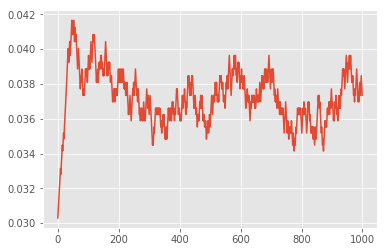

In [32]:
plt.plot(_ml_result.step_size)
# plt.yscale('log')
plt.show()

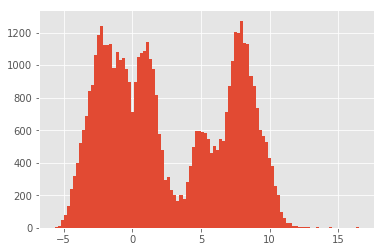

In [33]:
plt.hist(_ml_result.x_samples.flatten(),bins=100)
plt.show()

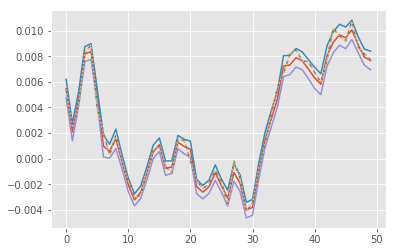

In [34]:

tec = 1e-3*np.mean(_ml_result.x_samples,axis=0).mean(0).reshape([Nt,1,1])
tec_s = 1e-3*np.sqrt(np.var(_ml_result.x_samples,axis=0).mean(0)).reshape([Nt,1,1])
plt.plot(tec[:,0,0])
plt.plot(tec[:,0,0]+tec_s[:,0,0])
plt.plot(tec[:,0,0]-tec_s[:,0,0])
# plt.show()
plt.plot(np.median(np.angle(gains)[0,0,0,:,:]*freqs[:,None]/-8.448e9,0),ls='--')
plt.plot(np.median(phase[0,0,0,:,:]*freqs[:,None]/-8.448e9,0),ls='dotted')
plt.show()



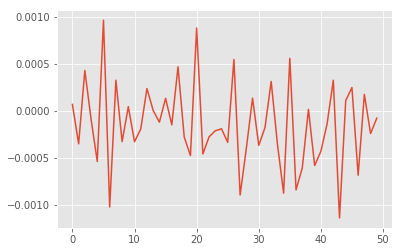

In [35]:
plt.plot(tec[:,0,0]-np.median(np.angle(gains)[0,0,0,:,:]*freqs[:,None]/-8.448e9,0))
plt.show()

In [78]:
# plt.plot(tec[:,0,0] - np.median(phase[0,0,0,:,:]*freqs[:,None]/-8.448e9,0))
# plt.show()

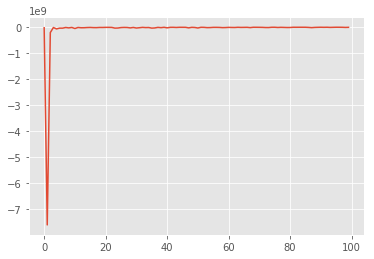

In [174]:
plt.plot(logp_array)
plt.show()

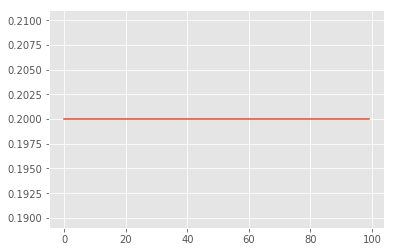

In [175]:
plt.plot(amp_array)
plt.show()

In [17]:


    


# from collections import namedtuple

# DataStream = namedtuple('DataStream',['Xt', 'Xd', 'Xa','Yt', 'St'])
# ScreenStream = namedtuple('ScreenStream',['Xd', 'Xa'])

# def iteration_moving_activate_set_while_loop(data_coords, screen_coords, 
#                                              kern, freqs,
#                                              X0 = None, x0=None, resume=None,
#                                             num_leapfrog_steps=2,
#                                             target_rate=0.75,
#                                             num_samples=100,
#                                             num_chains=2,
#                                             hyper_params = None,
#                                             train_freq=5,
#                                             num_train_steps = 10):
#     """Perform one iteration of RGP.
#     Args:
#     :param data_coords: DataStream contains Tensors for constructing the data.
#     :param screen_coords: ScreenStream contains Tensors for constructing the coordinates of screen.
#     :param basis_coords: BasisStream contains Tensors for constructing the coordinates of basis.
#     :param kern: gp.kernels.Kernel the covariance of GP
#         Signature: (N, ndim) -> (D, N, N)
#     :param mean: callable the mean of GP, 
#         Signature: (N, ndim) -> (D, N)
#     :param Nb: int Tensor num of points along time for basis
#     :param dt: float Tensor spacing of basis points in time
#     :param lag: int Tensor lag behind in indices to wait before posterior prediction at screen
#     :param X0: Tensor (S, ndim) init coords or None
#     :param C0: Tensor (S,S) init covariance or None
#     :param mu0: Tensor (D,S) init mean or None
#     :param resume: Tensor bool, whether to use given inits
    
        
#     Returns:
#     tensor arrays
#     """
    
#     # len of data stream and also the screen stream
#     Nt = tf.shape(data_coords.Xt)[0]
#     D = tf.shape(data_coords.Yt)[0]
#     Nf = tf.shape(freqs)[0]
#     data_shape = [D, -1, Nf]
    
    
#     def _timer():
#         return tf.py_func(default_timer,[],tf.float64,stateful=True)
    
#     def _make_coord_array(*X):
#         return tf.py_func(make_coord_array,X,tf.float64,stateful=False)
    
#     def _data_stream(i):
#         i = tf.maximum(tf.minimum(i, Nt-1), 0)
#         #N, ndims
#         X = _make_coord_array(data_coords.Xt[i:i+1,:], data_coords.Xd, data_coords.Xa)
#         #D,N,Nf
#         Y = tf.reshape(data_coords.Yt[:,i,:,:,:], data_shape)
#         S = tf.reshape(data_coords.St[:,i,:,:,:], data_shape)
#         return X,Y,S
    
#     def _not_done(i):
#         return tf.less(i,Nt)
    
#     def _screen_stream(i):
#         i = tf.minimum(tf.maximum(i, 0), Nt-1)
#         X = _make_coord_array(data_coords.Xt[i:i+1,:], screen_coords.Xd, screen_coords.Xa)
#         return X
    
#     def _get_init_prior():
        
#         X,Y,S = _data_stream(0)
#         phi = tf.atan2(Y[1,:,:],Y[0,:,:],name='phi0')
#         tec_conv = tf.cast(-8.448e6,tf.float64)/freqs
#         #M,N
#         tec0 = tfp.distributions.percentile(phi/tec_conv,50.0,axis=-1,name='tec0')[None,:]
#         #M,N,N
#         K = kern(X)
#         #M,N,N
#         L = tf.cholesky(K+tf.cast(jitter,tf.float64)*tf.eye(tf.shape(K)[1],dtype=tf.float64))
#         print(L)
#         #1, num_chains, M,N
#         x0 = tf.tile(tf.matrix_triangular_solve(L,tec0[:,:,None])[None,None,:,:,0], [1, num_chains, 1,1])
    
#         return X, x0, L
        
        
    
#     ###
#     # Make dataset streams
#     dataset = tf.data.Dataset.from_tensor_slices(tf.range(Nt+1,dtype=tf.int32))
#     index_dataset = dataset.make_initializable_iterator()
#     not_done_dataset = dataset.map(_not_done, num_parallel_calls=10).make_initializable_iterator()
#     data_dataset = dataset.map(_data_stream ,num_parallel_calls=10).make_initializable_iterator()
#     screen_dataset = dataset.map(_screen_stream ,num_parallel_calls=10).make_initializable_iterator()
    
#     inits = tf.group([index_dataset.initializer,
#             data_dataset.initializer,
#             not_done_dataset.initializer,
#             screen_dataset.initializer])
    
#     with tf.control_dependencies([inits]):
#         t0 = _timer()

#     data_X_ta = tf.TensorArray(tf.float64,size=Nt)
#     data_x_ta = tf.TensorArray(tf.float64,size=Nt)
#     data_y_ta = tf.TensorArray(tf.complex128,size=Nt)
    
#     screen_X_ta = tf.TensorArray(tf.float64,size=Nt)
#     screen_x_ta = tf.TensorArray(tf.float64,size=Nt)
#     screen_y_ta = tf.TensorArray(tf.complex128,size=Nt)

#     log_prob_ta = tf.TensorArray(tf.float64,size=Nt)
    
#     hyper_params_ta = tf.TensorArray(tf.float64,size=Nt)
    
#     step_size = tf.get_variable(
#                 name='step_size',
#                 initializer=tf.constant(1e-3,dtype=tf.float64),
#                 use_resource=True,
#                 trainable=False)
    
#     def _cond(*args):
#         return not_done_dataset.get_next()
    
#     def _body(last_posterior, last_X, last_L, 
#               data_X_ta, data_x_ta, data_y_ta,screen_X_ta, 
#               screen_x_ta,screen_y_ta, log_prob_ta,
#              hyper_params_ta):
                
#         i = index_dataset.get_next()
#         #N ndims, D M N, D M N
#         X_data, Y, Y_std = data_dataset.get_next()
#         N = tf.shape(X_data)[0]
#         #H ndims
#         X_screen = screen_dataset.get_next()
#         H = tf.shape(X_screen)[0]
#         #N+H, ndims
#         X = tf.concat([X_data, X_screen], axis=0)
        
#         num_done = tf.cast(i,tf.float64)
#         num_left = tf.cast(Nt - i,tf.float64)
#         rate = (_timer() - t0)/num_done
#         time_left = num_left*rate
        
#         print_op = tf.print("iter:", i, 
#                           " done %:",  
#                           tf.cast(100*num_done/(num_done+num_left),tf.int32), 
#                           " Rate (s/iter):", rate, 
#                           " time left (s):", time_left,
#                           output_stream=sys.stdout)
        
#         P = TargetDistribution(kern, last_posterior,X,last_X,Y, Y_std,freqs,last_L)        
        
#         def _target_logp(z_t):     
#             return P.unnormalized_logp(z_t)
    
            
        

#         hmc = tfp.mcmc.HamiltonianMonteCarlo(
#                         target_log_prob_fn=_target_logp,
#                         num_leapfrog_steps=num_leapfrog_steps,#tf.random_shuffle(tf.range(3,60,dtype=tf.int64))[0],
#                         step_size=step_size,
#                         step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(target_rate=target_rate))

#         #num_chains, M, Np
#         q0 = tf.reduce_mean(last_posterior,axis=0)
#         with tf.control_dependencies([print_op]):
#             # Run the chain (with burn-in).
#             samples, kernel_results = tfp.mcmc.sample_chain(
#                 num_results=num_samples,
#                 num_burnin_steps=0,
#                 current_state=q0,
#                 kernel=hmc)
            
#             avg_acceptance_ratio = tf.reduce_mean(tf.exp(tf.minimum(kernel_results.log_accept_ratio, 0.)),name='avg_acc_ratio')
#             posterior_log_prob = tf.reduce_sum(kernel_results.accepted_results.target_log_prob,name='marginal_log_likelihood')
            
# #             loss = tf.negative(posterior_log_prob,name='hyperparam_loss')
            
# #             def train_body(i):
# #                 opt = tf.train.AdamOptimizer(1e-1).minimize(loss,var_list=hyper_params)
# #                 with tf.control_dependencies([opt]):
# #                     return [i+1]
                
# #             train_hyper_params = tf.while_loop(lambda i: i < num_train_steps,
# #                                          train_body,
# #                                          [tf.constant(0)],
# #                                          back_prop=False)
            
# #             train_op = tf.cond(tf.equal(tf.mod(i, train_freq),-1), 
# #                             lambda: train_hyper_params,
# #                             lambda:loss)
            
#             ###
#             # transform samples
#             #N+H,N+H
#             L = P.L00[0,:,:]
#             #S, num_chains, N+H
#             z_t = samples[:,:,0,:]
#             #S, num_chains, N+H
#             tec_post = tf.einsum("nm,spm->spn",L, z_t)
#             #Nf
#             tec_conv = tf.cast(-8.448e6,tf.float64)/freqs
#             #Nf
#             phi_post = tec_post[:,:,:,None]*tec_conv
#             #S,num_chains, N+H, Nf
#             g_post = tf.complex(tf.cos(phi_post), tf.sin(phi_post))
#             #N+H, Nf
#             g_post_mean = tf.reduce_mean(g_post,axis=[0,1],name='g_post_mean')
#             g_post_var = tf.subtract(tf.reduce_mean(tf.square(g_post),axis=[0,1]), tf.square(g_post_mean),name='g_post_var')
#             #N+H
#             tec_post_mean = tf.reduce_mean(tec_post,axis=[0,1],name='tec_post_mean')
#             tec_post_var = tf.subtract(tf.reduce_mean(tf.square(tec_post),axis=[0,1]), tf.square(tec_post_mean),name='tec_post_var')
            
#             with tf.control_dependencies([inits]):
#                 return [samples, 
#                         X, 
#                         P.L00, 
#                         data_X_ta.write(i, X_data), 
#                         data_x_ta.write(i, tf.stack([tec_post_mean[:N], tec_post_var[:N]],axis=0)),
#                         data_y_ta.write(i, tf.stack([g_post_mean[:N,:], g_post_var[:N,:]], axis=0)),
#                         screen_X_ta.write(i, X_screen),
#                         screen_x_ta.write(i, tf.stack([tec_post_mean[N:], tec_post_var[N:]],axis=0)),
#                         screen_y_ta.write(i, tf.stack([g_post_mean[N:,:], g_post_var[N:,:]], axis=0)),
#                         log_prob_ta.write(i, posterior_log_prob),
#                         hyper_params_ta.write(i, tf.stack(hyper_params,axis=0))]
                
#     X, x0, L0 = _get_init_prior()
        
        
    
                                 
#     loop_vars = [x0, X, L0, 
#               data_X_ta, data_x_ta, data_y_ta,screen_X_ta, 
#               screen_x_ta,screen_y_ta, log_prob_ta,
#              hyper_params_ta]
#     shape_invariants = [tf.TensorShape([None, num_chains, None, None]), 
#                         X.shape,
#                         L0.shape,
#                         tf.TensorShape(None),
#                         tf.TensorShape(None),
#                         tf.TensorShape(None),
#                         tf.TensorShape(None),
#                         tf.TensorShape(None),
#                         tf.TensorShape(None),
#                         tf.TensorShape(None),
#                         tf.TensorShape(None)]
    
#     with tf.control_dependencies([inits]):
#         (x0, X, L0, 
#               data_X_ta, data_x_ta, data_y_ta,screen_X_ta, 
#               screen_x_ta,screen_y_ta, log_prob_ta,
#              hyper_params_ta) = tf.while_loop(_cond,
#                                _body,
#                                loop_vars,
#                                parallel_iterations=2,shape_invariants=shape_invariants)
    
#     return [data_X_ta.stack(), 
#             data_x_ta.stack(), 
#             data_y_ta.stack(),
#             screen_X_ta.stack(),
#             screen_x_ta.stack(),
#             screen_y_ta.stack(), 
#             log_prob_ta.stack(),
#             hyper_params_ta.stack()]
            



# def basis_antennas(X_a, N=5):
#     N = np.minimum(N,X_a.shape[0])
# #     if N <= X_a.shape[0]:
#     C_a, idx = kmeans2(X_a,N, iter=10000,minit='points')
# #     return C_a
# #     C_a, idx = kmeans2(X_a,N, iter=10000,minit='random')

#     return C_a


# def basis_directions(X_d, f_min=0.5, f_max=0.75, fov=5., N=7, dialate=False):
#     l = np.linspace(-fov/2.,fov/2,N)
#     dirs = np.meshgrid(l, l,indexing='ij')
    
#     if dialate:
#         dl = l[1] - l[0]
#         #f_max = dl * (a + b * |fov|/2)
#         #f_min = dl * (a)
#         a = f_min / dl
#         b = (f_max / dl - a)* 2. / fov


#         R = np.sqrt(dirs[0]**2 + dirs[1]**2)
#         dialate = a + b * R
#         dirs[0] *= dialate
#         dirs[1] *= dialate
    
#     dirs = np.stack([dirs[0].flatten(), dirs[1].flatten()], axis=1)
#     C_d, idx = kmeans2(X_d,dirs, iter=10000,minit='matrix')
    
#     return C_d



# def basis_time(t, dt=15., N=40):
#     return np.linspace(t - dt*N/2., t + dt*N/2., N)[:,None]


# def gains_mean( freq, sigma_tec, mean_amp=1.):
#     """Returns mean of real and imaginary pary"""
#     mean_real = mean_amp * np.exp(-0.5*(8.448e9*sigma_tec/freq[:,None])**2 )
#     mean_imag = np.zeros_like(mean_real)
#     return mean_real, mean_imag

# def flag_facets(phase, X_d):
#     """
#     :param phase: array (Npol, Nd, Na, Nf, Nt)
#     :param X_d: array (Nd,2)
#     Returns:
#     (Nd,Na,Nf)
#     """
#     from scipy.stats import linregress
#     def wrap(phi):
#         return np.angle(np.exp(1j*phi))
    
#     Npol, Nd, Na, Nf, Nt = phase.shape
#     #Nd
#     dist = np.linalg.norm(X_d,axis=1)
#     #Npol, Nd, Na, Nf
#     m = np.mean(wrap(wrap(phase[...,1:]) - wrap(phase[...,0:-1]))**2,axis=-1)
#     flags = np.zeros([Nd,Na,Nf])
#     for i in range(Na):
#         for l in range(Nf):
#             y = m[0,:,i,l]
#             s, yint, _,_,_ = linregress(dist, y)
#             if s==0:
#                 continue
#             # remove 5 sigma points
#             y_pred = yint + s*dist
#             std = np.sqrt(np.mean((y-y_pred)**2))
            
#             flag = np.where(np.abs(y-y_pred)/std > 5)[0]
#             if len(flag) != 0:
#                 flags[flag,i,l] = 1
#             select = ~np.isin(np.arange(Nd),flag)
#             s, yint, _,_,_ = linregress(dist[select], y[select])
#             # remove 5 sigma points
#             y_pred = yint + s*dist
#             std = np.sqrt(np.mean((y[select]-y_pred[select])**2))
#             flag = np.where(np.abs(y-y_pred)/std > 2.)[0]
#             if len(flag) != 0:
#                 flags[flag,i,l] = 1
            
#     return flags

In [18]:
# import os

# posterior_solset = 'posterior_sol_15'
# datapack = '/home/albert/git/bayes_tec/scripts/data/DR2_full_smoothed.h5'
# output_folder='./nonlinear_rgp/test'
# os.makedirs(output_folder,exist_ok=True)

# ant_sel = 'RS210HBA'#slice(1,None,1)
# time_sel = slice(0,100,1)
# dir_sel = slice(0,None,1)
# freq_sel = slice(0,None,1)
# pol_sel = slice(0,1,1)

# train_time=True
# train_dir=True
# train_ant=True
# train_dot=True
# dot_degree=1.



# with DataPack(datapack,readonly=False) as datapack:
#     make_solsets(datapack,posterior_solset, screen_res=15, extend = 0., solset='sol000')
#     datapack.select(ant=ant_sel,
#                     freq=freq_sel,
#                     time=time_sel,
#                     dir=dir_sel, 
#                     pol=pol_sel)
#     datapack.switch_solset('sol000')
#     phase, axes = datapack.phase
#     _, Nd, Na, Nf, Nt = phase.shape
# #     amp, axes = datapack.amplitude
#     datapack.switch_solset(posterior_solset)
#     axes = datapack.axes_phase
#     patch_names, directions = datapack.get_sources(axes['dir'])
#     _, times = datapack.get_times(axes['time'])
#     _, freqs = datapack.get_freqs(axes['freq'])
#     antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    
# gains = np.exp(1j*phase)
# #Nt,Nd,Na,Nf
# gains = gains[0,...].transpose((3,0,1,2))

# #2, Nt, Nd, Na, Nf
# Y = np.stack([gains.real, gains.imag], axis = 0)
# Y_var = calculate_weights(Y,indep_axis=1, N=4,phase_wrap=False,min_uncert=0.01)


# antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
# X_a = np.array([antennas_enu.east.value,
#                 antennas_enu.north.value]).T/1000.
# X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), directions.dec.deg - directions.dec.deg.mean()]).T
# X_t = (times.mjd*86400 - times[0].mjd*86400.)[:,None]

# ###
# # custom uncertainties
# #Nd,Na,Nf
# flags = np.where(flag_facets(phase, X_d))
# flag_dirs = np.unique(flags[0])
# select_dirs = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))[0]
# Y_var[:,:,flags[0], flags[1], flags[2]] += 300.

# D = 2

# ###
# # Get screen directions
# with datapack:
#     datapack.select(ant=ant_sel,
#                     freq=freq_sel,
#                     time=time_sel,
#                     dir=slice(0,None,1), 
#                     pol=pol_sel)
#     _, X_screen_d, _ = get_solset_coords(datapack, 'screen_{}'.format(posterior_solset))

# data_coords_np = DataStream(X_t, X_d, X_a,  Y, np.sqrt(Y_var))
# screen_coords_np = ScreenStream(X_screen_d, X_a)

# with tf.Session(graph=tf.Graph()) as sess:

#     data_coords = DataStream(tf.placeholder(tf.float64,shape=X_t.shape), 
#                              tf.placeholder(tf.float64,shape=X_d.shape), 
#                              tf.placeholder(tf.float64,shape=X_a.shape), 
#                              tf.placeholder(tf.float64,shape=Y.shape),
#                              tf.placeholder(tf.float64,shape=Y_var.shape))
#     screen_coords = ScreenStream(tf.placeholder(tf.float64,shape=X_screen_d.shape),
#                                  tf.placeholder(tf.float64,shape=X_a.shape))
    
#     freqs_pl = tf.placeholder(tf.float64,shape=freqs.shape)
#     ###
#     # Define kernel 
#     kern_time = gp.kernels.Matern52(1, active_dims = slice(0,1,1))
#     kern_time.lengthscales = 99.0
#     kern_time.lengthscales.trainable = train_time
#     kern_time.variance.trainable = False
#     kern_dir = gp.kernels.RBF(2, active_dims = slice(1,3,1))
#     kern_dir.lengthscales = 1.150
#     kern_dir.lengthscales.trainable = train_dir
#     kern_dir.variance.trainable = False
#     kern_ant = gp.kernels.Matern12(2, active_dims = slice(3,5,1),variance=1.)
#     kern_ant.lengthscales = 11.0
#     kern_ant.lengthscales.trainable = train_ant
#     kern_ant.variance.trainable = False
#     # dependence on distance from center 
#     kern_dot = gp.kernels.Polynomial(2, degree=dot_degree, variance=0.01211, offset=0.81261, active_dims = slice(1,3,1))
# #     kern_freq = gp.kernels.RBF(1, active_dims = slice(5,6,1))
# #     kern_freq.lengthscales = 2.
#     kern = gp.multioutput.SharedIndependentMok(kern_time*kern_dir*kern_ant*kern_dot,D)
#     def _kern(X,X2=None):
#         return kern.K(X,X2,full_output_cov=False)

#     (data_X, 
#     data_x, 
#     data_y,
#     screen_X,
#     screen_x,
#     screen_y, 
#     log_prob,
#     hyper_params) = iteration_moving_activate_set_while_loop(data_coords, 
#                                                          screen_coords, 
#                                                         _kern, 
#                                                         freqs_pl,
#                                                         num_leapfrog_steps=2,
#                                                         target_rate=0.75,
#                                                         num_samples=2,
#                                                         num_chains=2,
#                                                         hyper_params = kern.trainable_tensors,
#                                                         train_freq=5,
#                                                         num_train_steps = 10)
#     def _add_feed(d,pl,vl):
#         for p,v in zip(pl,vl):
#             d[p] = v
#         return d
    
#     feed_dict = _add_feed({freqs_pl:freqs},data_coords, data_coords_np)
#     feed_dict = _add_feed(feed_dict,screen_coords, screen_coords_np)
    
#     res = sess.run({'data_X':data_X, 
#                     'data_x':data_x, 
#                     'data_y':data_y, 
#                     'screen_X':screen_X, 
#                     'screen_x':screen_x, 
#                     'screen_y':screen_y,
#                     'log_prob':log_prob,
#                     'hyper_params':hyper_params},
#                    feed_dict)
    

In [19]:
# with tf.Session(graph=tf.Graph()) as sess:
    
#     def simulate(tec):
# #         tec = np.array([1e-3,1e-2,1e-1])
#         tec = tec
#         freqs = np.linspace(120e6,160e6,10)
#         tec_conv = -8.448e9/freqs
#         phi = tec[:,None]*tec_conv[None,:]
#         g = tf.stack([tf.cos(phi),tf.sin(phi)],axis=0)
#         return g
    
#     _y = sess.run(simulate(np.array([1e-2])))
#     _y += 0.3*np.random.normal(size=_y.shape)
#     y = tf.convert_to_tensor(_y,dtype=tf.float32)
#     sigma = 0.3*tf.ones(y.shape[1],dtype=tf.float32)
    
#     def likelihood(q):
#         g = simulate(q)
#         logp = tfp.distributions.Laplace(loc=g, scale=sigma).log_prob(y)#MultivariateNormalDiag(loc=y[0,...],scale_identity_multiplier=0.3).log_prob(g[0,...]) + tfp.distributions.MultivariateNormalDiag(loc=y[1,...], scale_identity_multiplier=0.3).log_prob(g[1,...])
#         return tf.reduce_sum(logp)
    
#     def prior(q):
#         return tfp.distributions.MultivariateNormalDiag(loc=0.*q,scale_identity_multiplier=0.05).log_prob(q)
        
        
#     def logp_func(q):
#         """
#         :param q: float Tensor [3, 1]
#         returns:
#         float Tensor scalar [1]
#         """
#         return tf.reduce_sum(likelihood(q) + prior(q))
# #         N = tfp.distributions.MultivariateNormalDiag(loc=tf.constant(np.arange(3,dtype=float),dtype=tf.float32),
# #                                                      scale_diag=tf.constant(np.sqrt(np.array([1,1.2,1.9])), dtype=tf.float32))
# #         return N.log_prob(tf.transpose(q))
    
#     def grad_logp_func(q):
#         """
#         :param q: float Tensor [3, 1]
#         returns:
#         float Tensor scalar [3,1]
#         """
#         f = logp_func(q)
#         return tf.gradients(f,q)[0]
    
    
    
#     target_logp = lambda x: tfp.math.custom_gradient(logp_func(x),grad_logp_func(x),x)
    
#     step_size = tf.get_variable(
#                         name='step_size',
#                         initializer=1e-3,
#                         use_resource=True,
#                         trainable=False)
    
#     hmc = tfp.mcmc.HamiltonianMonteCarlo(
#                     target_log_prob_fn=logp_func,
#                     num_leapfrog_steps=2,#tf.random_shuffle(tf.range(3,60,dtype=tf.int64))[0],
#                     step_size=step_size,
#                     step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(target_rate=0.75))
    
#     q0 = 0.0*tf.ones(1, dtype=float_type)
    
#     # Run the chain (with burn-in).
#     samples, kernel_results = tfp.mcmc.sample_chain(
#         num_results=int(1e4),
#         num_burnin_steps=int(1e2),
#         current_state=q0,
#         kernel=hmc)
    
#     post_g = simulate(samples)
    
#     init_op = tf.global_variables_initializer()
    
#     sess.run(init_op)
    
#     _post_g, _samples,_kern_res = sess.run([post_g, samples, kernel_results])
    
    
    
    
# #     q0 = tf.reshape(tf.zeros(3, dtype=float_type),(3,1))
# #     C_q = tf.eye(3,dtype=float_type)
# #     stepsize = 1.
# #     per_sample_size = 1
# #     max_L = 1000
    
# # #     print(sess.run(logp_func(q0)))
# # #     print(sess.run(grad_logp_func(q0)))

# #     num_samples = 1
    
# #     samples, acc_prob = hmc_chain(num_samples, logp_func, grad_logp_func, q0, C_q, stepsize, per_sample_size, max_L)
    
# #     _samples, _acc_prob = sess.run([samples,acc_prob])

In [20]:
# def hmc_chain(num_samples, logp_func, grad_logp_func, q0, C_q, stepsize, per_sample_size=1, max_L = 10):
#     """
#     :param logp_func: callable(q->Tensor(N,M))
#     :param grad_logp_func: callable(q->Tensor(N,M))
#     :param q0: Tensor (N,1)
#     """
    
#     q0 = tf.cast(q0,float_type)
#     C_q = tf.cast(C_q, float_type)
#     _per_sample_size = per_sample_size
#     num_samples = tf.convert_to_tensor(num_samples,dtype=tf.int32,name='num_samples')
#     per_sample_size = tf.convert_to_tensor(per_sample_size,dtype=tf.int32,name='per_sample_size')
#     stepsize = tf.convert_to_tensor(stepsize, dtype=float_type, name='stepsize')
#     max_L = tf.convert_to_tensor(max_L,dtype=tf.int32, name='max_L')
    
#     #N,N
#     L_q = tf.cholesky(C_q + jitter*tf.eye(tf.shape(C_q)[0],dtype=float_type),name='L_q')
    
        
#     def hmc_iteration(q0):
#         """
#         :param q0: Tensor (N,1)
#         :param stepsize: float Tensor
#         :param num_sample: int
#         returns:
#         Tensor [per_sample_size, N, 1]
#         """
        
#         def hamiltonian(q,p):
#             """
#             :param q0: Tensor [N, M]
#             :param p0: Tensor [N, M]
#             returns:
#             Tensor [M]
#             """
#             N = tf.shape(q)[0]
#             #[M]
#             V = tf.negative(logp_func(q),name='V')
#             #N,M
#             dp = tf.matmul(L_q, p, transpose_a=True,name='dp')
#             #M
#             K = 0.5*tf.reduce_sum(tf.square(dp), axis=-2,name='K') 
#             K += 0.5*tf.cast(N,float_type)*np.log(2*np.pi)
#             K -= 0.5*tf.reduce_sum(tf.log(tf.matrix_diag_part(L_q)),axis=-1,name='K')
#             return tf.add(V, K, name='H')

#         def qdot(p):
#             """
#             :param p: Tensor [N,M]
#             Returns:
#             Tensor [N,M]
#             """
#             #N,M
#             return tf.matmul(C_q, p, name='qdot')

#         def pdot(q):
#             """
#             :param q: Tensor [N,M]
#             Returns:
#             Tensor [N,M]
#             """
#             return tf.negative(grad_logp_func(q),name='pdot')

#         def _get_step_sizes(f,stepsize):
#             """
#             :param f: float Tensor scalar
#             :param stepsize: float Tensor scalar
#             Returns:
#             float Tensor [2]
#             """
#             step_f = 2*f*stepsize
#             step_b = -2*(1-f)*stepsize
#             return tf.concat([[step_f],[step_b]],axis=0,name='stepsizes')
        
#         def _integration_step(q0,p0,stepsize):
#             """
#             :param q0: Tensor [N, 2]
#             :param p0: Tensor [N, 2]
#             :param stepsize: Tensor [2]
#             Returns:
#             Tensor [N,2]
#             Tensor [N,2]
#             """
# #             c1,c2 = 0., 1.
# #             d1,d2 = 0.5, 0.5
#             #N,2
#             q1 = q0
            
#             #N,2
#             pd0 = pdot(q1)
#             p1 = tf.add(p0,0.5*stepsize*pd0,name='p1')
            
#             #N,2
#             qd1 = qdot(p1)
#             q2 = tf.add(q1, stepsize*qd1,name='q2')
            
#             #N,2
#             pd1 = pdot(q2)
#             p2 = tf.add(p1, 0.5*stepsize*pd1,name='p2')
            
#             #2
#             h = hamiltonian(q2,p2)
#             h = tf.Print(h,[h,pd1])
#             return q2, p2, h
        
#         ###
#         # variables passed to all functions in scope
#         step = _get_step_sizes(tf.random_uniform([],dtype=float_type),stepsize)
#         p0 = tf.matrix_triangular_solve(L_q,
#                                        tf.random_normal(tf.shape(q0),dtype=float_type,name='Z_p'),name='p0')
#         h0 = hamiltonian(q0,p0)
        
#         IterationResult = namedtuple('IterationResult',
#                                      ['i','q','p','dq','accepted','acceptance_prob'])  
        
#         def _body(v):
            
            
#             q,p,h = _integration_step(v.q, v.p, step)
            
#             #N
#             dq = tf.add(v.dq,tf.reduce_sum(tf.abs(step)*p,axis=1,keepdims=True,name='delta_dq'), name='dq')
            
#             accepted = v.accepted
#             dh = tf.subtract(h, h0, name='dh')
#             accept_f = tf.less(tf.log(tf.random_uniform([],dtype=float_type)), dh[0],name='accept_f')
#             accepted = accepted.write(v.i+1, tf.cond(accept_f, 
#                                                    lambda: q[:,0:1], 
#                                                    lambda: q0))
#             accept_b = tf.less(tf.log(tf.random_uniform([],dtype=float_type)), dh[1],name='accept_b')
#             accepted = accepted.write(v.i+2, tf.cond(accept_b, 
#                                                    lambda: q[:,1:2], 
#                                                    lambda: q0))
            
            
#             acceptance_prob = tf.add(v.acceptance_prob, tf.reduce_sum(tf.clip_by_value(tf.exp(dh),0., 1.),name='delta_acc_prob'),name='acc_prob')
            
            
#             return [v._replace(i=v.i+2, 
#                                q = q, 
#                                p=p, 
#                                dq=dq, 
#                                accepted=accepted, 
#                                acceptance_prob=acceptance_prob)]
        
#         def _cond(v):
# #             dq = q_f - q_b
#             #N, 2
#             p_sharp = tf.matmul(C_q, v.p,name='p_sharp')
#             #2
#             cond = tf.greater(tf.reduce_sum(p_sharp*v.dq[:,None],axis=0), 0., name='nuts_cond')
#             return tf.logical_or(tf.less(v.i,1),tf.reduce_any(cond,name='nuts_cond'))
        
        
        
#         accepted = tf.TensorArray(float_type,
#                                   size=max_L,
#                                   dynamic_size=True,
#                                   element_shape=q0.shape,
#                                   name='accepted_ta')
        
#         loop_vars = IterationResult(i=tf.constant(0), 
#                                     q=tf.concat([q0,q0],axis=1),
#                                     p=tf.concat([p0,p0],axis=1),
#                                     dq=tf.zeros_like(q0),
#                                     accepted=accepted,
#                                     acceptance_prob=tf.constant(0.,dtype=float_type))
        
#         out_vars = tf.while_loop(
#             _cond,
#             _body,
#             [loop_vars],
#             parallel_iterations=1,
#             back_prop=False,
#             name='hmc_chain_iteration')[0]
        
#         accepted = out_vars.accepted.stack()
#         accepted = tf.Print(accepted,[tf.shape(accepted),accepted])
#         acceptance_prob = tf.div(out_vars.acceptance_prob,  tf.cast(out_vars.i, dtype=float_type),name='acc_prob_mean')
        
#         ###
#         # Uniformly sample from the transition
#         idx = tf.cast(tf.random_shuffle(tf.range(out_vars.i))[:per_sample_size],tf.int32,name='iteration_select')
    
#         #per_sample_size, N, 1
#         output = tf.gather(accepted,idx,axis=0,name='iteration_samples')
#         output = tf.Print(output,[tf.shape(output),output, idx,out_vars.i])
#         return output, acceptance_prob
    
    
#     def sample_chain(q0):
#         """
#         :param q0: float Tensor [N, 1]
#         Returns:
#         float Tensor [num_samples, N, 1]
#         float Tensor scalar
#         """
        
#         ChainResult = namedtuple('ChainResult',['S','samples_ta', 'acc_prob','last_q'])
        
#         def _body(v):
#             """Update all sub-chains"""
#             SubChainResult = namedtuple('SubChainResult',['i','sub_chain_ta','acc_prob'])
            
#             def _sub_body(sub_v):
#                 """Get the sub_chain at i"""
#                 #N, 1
#                 q = v.last_q[sub_v.i,:,:]
#                 #per_sample_size, N, 1  
#                 q_sub_chain, acc_prob = hmc_iteration(q)
#                 sub_chain_ta = sub_v.sub_chain_ta.write(sub_v.i, q_sub_chain)
#                 acc_prob = sub_v.acc_prob + acc_prob
                
#                 return [sub_v._replace(i=sub_v.i+1, 
#                                     sub_chain_ta = sub_chain_ta,
#                                     acc_prob=acc_prob)]
            
#             def _sub_cond(sub_v):
#                 return tf.less(sub_v.i,tf.shape(v.last_q)[0])
                
#             ele_shape = tf.TensorShape([_per_sample_size]+q0.shape.as_list())
#             sub_chain_ta = tf.TensorArray(float_type,
#                                     size=per_sample_size,
#                                     element_shape=ele_shape,
#                                     name='sub_samples_ta')
            
#             _sub_loop_vars = SubChainResult(i=tf.constant(0),
#                                            sub_chain_ta = sub_chain_ta,
#                                            acc_prob = tf.constant(0.,dtype=float_type))
            
#             sub_out_vars = tf.while_loop(_sub_cond,
#                                          _sub_body,
#                                          [_sub_loop_vars],
#                                          parallel_iterations=32,
#                                          back_prop=False,
#                                          name='sub_chain_sampler')[0]
            
#             #len(last_q), per_sample_size, N, 1
#             sub_samples = sub_out_vars.sub_chain_ta.stack()
#             sub_samples = tf.Print(sub_samples,[tf.shape(sub_samples)])
#             #len(last_q)*per_sample_size, N, 1
#             sub_samples = tf.reshape(sub_samples, 
#                                      tf.concat([[tf.constant(-1)], tf.shape(q0)],axis=0),name='sub_samples')
            
#             new_S = tf.shape(sub_samples)[0]
#             scatter_idx = tf.range(v.S, v.S + new_S,dtype = tf.int32,name='scatter_idx')
#             samples_ta = v.samples_ta.scatter(scatter_idx, sub_samples)
            
#             acc_prob = tf.div(sub_out_vars.acc_prob, tf.cast(tf.shape(v.last_q)[0],float_type), name='sub_chain_acc_prob')
            
#             return [v._replace(S=v.S + new_S,
#                              samples_ta = samples_ta,
#                              acc_prob = acc_prob,
#                              last_q = sub_samples)]
                
                
        
#         def _cond(v):
#             return tf.less(v.S, num_samples)
        
#         samples_ta = tf.TensorArray(float_type,
#                                     size=num_samples,
#                                     dynamic_size=True,
#                                     element_shape=q0.shape,
#                                     name='samples_ta') 
        
#         loop_vars = ChainResult(S = tf.constant(0,dtype=tf.int32),
#                                samples_ta = samples_ta,
#                                acc_prob = tf.constant(0.,dtype=float_type),
#                                last_q = q0[None, :, :])
        
#         shape_invariants = ChainResult(S = loop_vars.S.shape,
#                                samples_ta = tf.TensorShape(None),
#                                acc_prob = loop_vars.acc_prob.shape,
#                                last_q = tf.TensorShape([None]+q0.shape.as_list()))
        
#         out_vars = tf.while_loop(_cond,
#                                  _body,
#                                  [loop_vars],
#                                  back_prop=False,
#                                  parallel_iterations=1,
#                                  shape_invariants=[shape_invariants],
#                                  name='chain_sampler')[0]
        
#         #num_samples, N, 1
#         samples = out_vars.samples_ta.stack()
#         acc_prob = tf.div(out_vars.acc_prob, tf.cast(out_vars.S, float_type), name='chain_acc_prob')
        
#         return samples, acc_prob
    
#     return sample_chain(q0)
            
            
    
            
            
            
        
    